<a href="https://colab.research.google.com/github/Bishalroybd/Neural-net/blob/main/Multiclass_my_own_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Instead of using ipympl, use a supported backend like 'inline'
# %matplotlib ipympl
# This line will make plots appear within the Jupyter Notebook output
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
! pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download sovitrath/diabetic-retinopathy-224x224-2019-data

Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data
License(s): CC0-1.0


In [8]:
import zipfile
import os

# 1. Create the 'APTOS' folder if it doesn't exist
aptos_folder = '/content/APTOS'  # Define the path for the new folder
os.makedirs(aptos_folder, exist_ok=True)  # Create the folder

# 2. Define the path to the zip file
zip_file_path = '/content/diabetic-retinopathy-224x224-2019-data.zip'

# 3. Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 4. Extract all contents to the 'APTOS' folder
    zip_ref.extractall(aptos_folder)

print(f"Files extracted to: {aptos_folder}")

Files extracted to: /content/APTOS


In [9]:
import os

def list_folders(path):
  for root, dirs, files in os.walk(path):
    for dir_name in dirs:
      if not any(dir_name.lower().endswith(ext) for ext in ['.png', '.jpg']):
        print(os.path.join(root, dir_name))

list_folders('/content/APTOS')

/content/APTOS/colored_images
/content/APTOS/colored_images/Severe
/content/APTOS/colored_images/Proliferate_DR
/content/APTOS/colored_images/No_DR
/content/APTOS/colored_images/Mild
/content/APTOS/colored_images/Moderate


In [10]:
import os

def count_images(directory):
  """Counts the number of image files in a given directory and its subdirectories.

  Args:
    directory: The path to the directory to search.

  Returns:
    The total number of image files found.
  """
  image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')  # Add more if needed
  image_count = 0
  for root, _, files in os.walk(directory):
    for file in files:
      if file.lower().endswith(image_extensions):
        image_count += 1
  return image_count

# Example usage (assuming your images are in /content/APTOS):
aptos_image_count = count_images('/content/APTOS')
print(f"Total number of images found in /content/APTOS: {aptos_image_count}")

Total number of images found in /content/APTOS: 3662


In [11]:
def recall_m(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def precision_m(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

In [13]:
train_generator = train_datagen.flow_from_directory(
    r'/content/APTOS/colored_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    r'/content/APTOS/colored_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [14]:
def depthwise_separable_conv(inputs, filters, strides=1, use_se=False):
    """Depthwise Separable Convolution with optional SE block."""
    x = layers.DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if use_se:
        x = squeeze_excitation_block(x)

    return x

In [15]:
def squeeze_excitation_block(inputs, ratio=16):
    """Squeeze-and-Excitation block to improve feature importance learning."""
    filters = inputs.shape[-1]
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Dense(filters // ratio, activation='relu')(x)
    x = layers.Dense(filters, activation='sigmoid')(x)
    x = layers.Reshape((1, 1, filters))(x)
    return layers.Multiply()([inputs, x])

In [16]:
def build_model(input_shape=(224, 224, 3), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    # Initial Standard Convolution
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Depthwise Separable Blocks with SE
    x = depthwise_separable_conv(x, 64, strides=1, use_se=True)
    x = depthwise_separable_conv(x, 128, strides=2, use_se=True)  # Downsample to 112x112
    x = depthwise_separable_conv(x, 128, strides=1, use_se=True)
    x = depthwise_separable_conv(x, 256, strides=2, use_se=True)  # Downsample to 56x56
    x = depthwise_separable_conv(x, 256, strides=1, use_se=True)
    x = depthwise_separable_conv(x, 512, strides=2, use_se=True)  # Downsample to 28x28
    x = depthwise_separable_conv(x, 512, strides=1, use_se=True)
    x = depthwise_separable_conv(x, 1024, strides=2, use_se=True)  # Downsample to 14x14
    x = depthwise_separable_conv(x, 1024, strides=1, use_se=True)

    # Global Average Pooling and Fully Connected Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)  # Reduced from 256 to 128
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

In [17]:
# def build_model(input_shape=(224, 224, 3), num_classes=5):
#     inputs = layers.Input(shape=input_shape)

#     # Initial standard convolution
#     x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     # Depth-wise separable blocks with downsampling
#     x = depthwise_separable_conv(x, 64, strides=2)
#     x = depthwise_separable_conv(x, 64, strides=1)
#     x = depthwise_separable_conv(x, 128, strides=2)  # Downsample to 56x56
#     x = depthwise_separable_conv(x, 128, strides=1)
#     x = depthwise_separable_conv(x, 256, strides=2)  # Downsample to 28x28
#     x = depthwise_separable_conv(x, 256, strides=1)
#     x = depthwise_separable_conv(x, 512, strides=2)  # Downsample to 14x14
#     x = depthwise_separable_conv(x, 512, strides=1)
#     x = depthwise_separable_conv(x, 1024, strides=1)
#     x = depthwise_separable_conv(x, 1024, strides=2)
#     x = depthwise_separable_conv(x, 1024, strides=2)

#     # Global pooling and dense layers
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     return Model(inputs, outputs)

In [18]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [19]:
model = build_model()

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        320 │ re_lu[0][0]       │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      2,112 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ re_lu_2[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 112, 112,  │          0 │ re_lu_2[0][0],    │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 56, 56,    │        640 │ multiply[0][0]    │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 2,636,985 (10.06 MB)

 Trainable params: 2,623,289 (10.01 MB)

 Non-trainable params: 13,696 (53.50 KB)

In [21]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='acc'),
        f1_m,
        precision_m,
        recall_m
    ]
)

In [22]:
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), # Early Stopping
#     ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
# ]

In [23]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 116s 854ms/step - acc: 0.6850 - f1_m: 0.2271 - loss: 1.5358 - precision_m: 0.7103 - recall_m: 0.1387 - val_acc: 0.2739 - val_f1_m: 0.0000e+00 - val_loss: 1.7515 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 618ms/step - acc: 0.7888 - f1_m: 0.3889 - loss: 1.3850 - precision_m: 0.9406 - recall_m: 0.2477 - val_acc: 0.3218 - val_f1_m: 0.0000e+00 - val_loss: 1.9747 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 605ms/step - acc: 0.8043 - f1_m: 0.4163 - loss: 1.4047 - precision_m: 0.8898 - recall_m: 0.2746 - val_acc: 0.2811 - val_f1_m: 0.0000e+00 - val_loss: 2.0645 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 580ms/step - acc: 0.8213 - f1_m: 0.4253 - loss: 1.3487 - precision_m: 0.9094 - recall_m: 0.2821 - val_acc: 0.3057 - val_f1_m: 0.0000e+00 - val_loss: 2.4195 - val_precision_m: 0.0000e+00 - val_

In [24]:
model.save('diabetic_retinopathy_model_cnn .h5')

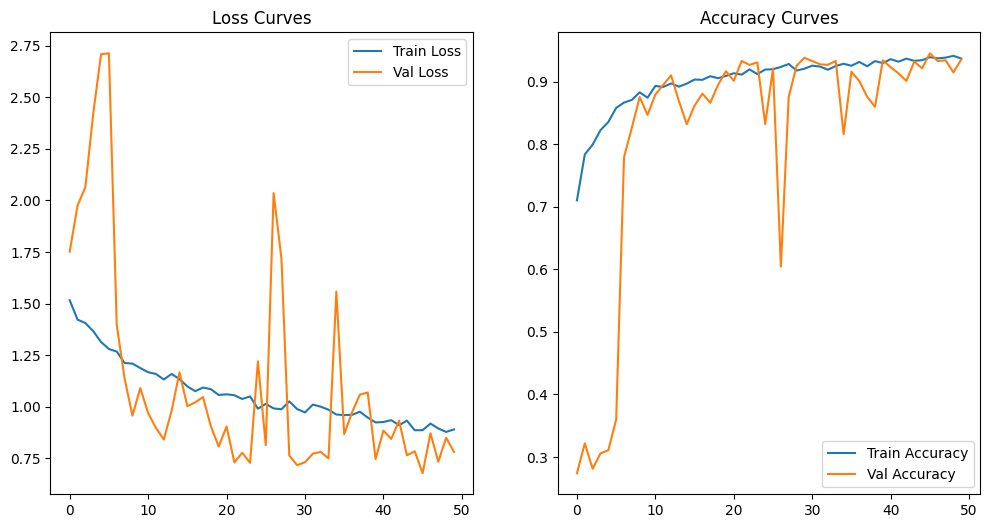

In [27]:
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Train Accuracy')  # Changed 'accuracy' to 'acc'
plt.plot(history.history['val_acc'], label='Val Accuracy') # Changed 'val_accuracy' to 'val_acc'
plt.title('Accuracy Curves')
plt.legend()

plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 447ms/step


Text(50.58159722222221, 0.5, 'True')

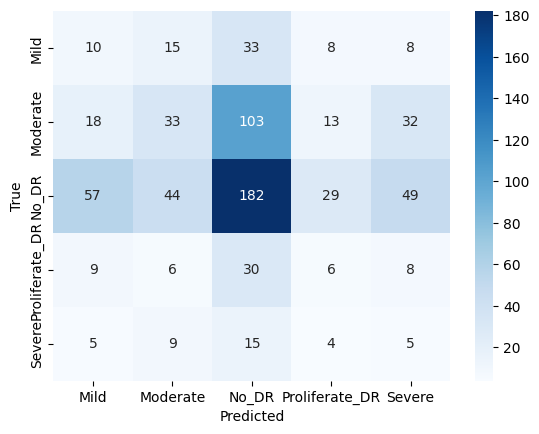

In [28]:
# Get predictions
y_pred = model.predict(validation_generator).argmax(axis=1)
y_true = validation_generator.classes

# Get class names from the generator
class_names = list(validation_generator.class_indices.keys())

# Plot
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 618ms/step


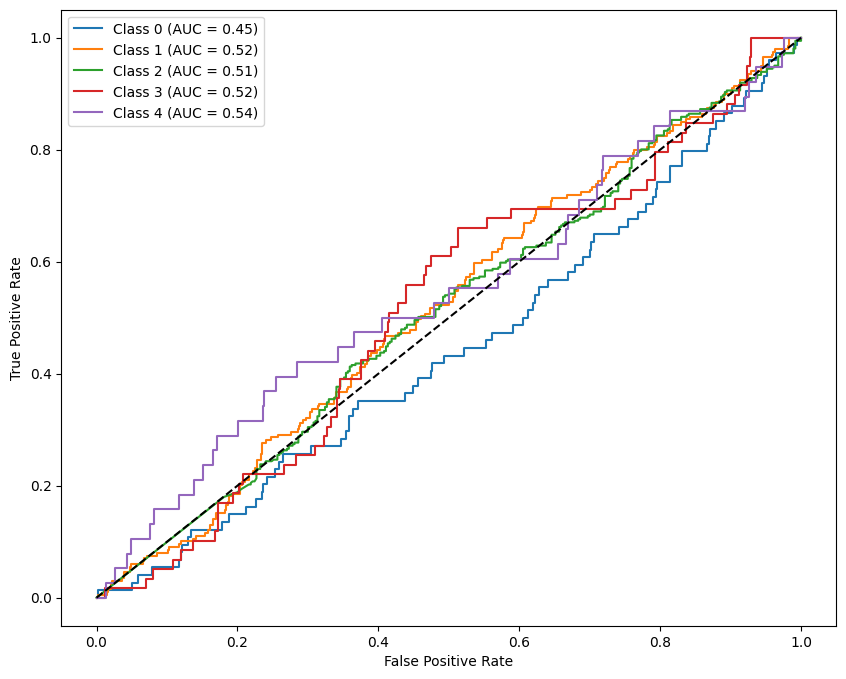

In [29]:
from sklearn.metrics import roc_curve, auc

# One-hot encode true labels
y_true = tf.keras.utils.to_categorical(y_true, num_classes=5)
y_pred_probs = model.predict(validation_generator)

plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_true[:,i], y_pred_probs[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


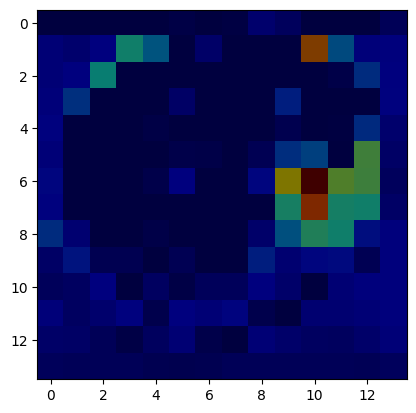

In [30]:
def grad_cam(img_array, model, last_conv_layer_name='depthwise_conv2d_5'):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Example usage
img = next(validation_generator)[0][0]  # Get a sample image
heatmap = grad_cam(np.expand_dims(img, axis=0), model)
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.show()

In [32]:
! kaggle datasets download sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
License(s): CC0-1.0


In [33]:
import zipfile
import os

# 1. Create the 'APTOS' folder if it doesn't exist
aptos_folder = '/content/APTOS'  # Define the path for the new folder
os.makedirs(aptos_folder, exist_ok=True)  # Create the folder

# 2. Define the path to the zip file
zip_file_path = '/content/diabetic-retinopathy-224x224-gaussian-filtered.zip'

# 3. Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 4. Extract all contents to the 'APTOS' folder
    zip_ref.extractall(aptos_folder)

print(f"Files extracted to: {aptos_folder}")

Files extracted to: /content/APTOS


Found 731 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - acc: 0.7050 - f1_m: 0.2612 - loss: 1.5325 - precision_m: 0.2818 - recall_m: 0.2468
Test loss: 1.0473
Test AUC:  0.8688
Test F1:   0.5017
Test Prec:0.5632
Test Rec: 0.4675
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step

Classification Report:

                precision    recall  f1-score   support

          Mild       0.07      0.03      0.04        74
      Moderate       0.73      0.16      0.26       199
         No_DR       0.88      0.93      0.90       361
Proliferate_DR       0.22      0.59      0.32        59
        Severe       0.12      0.37      0.18        38

      accuracy                           0.57       731
     macro avg       0.40      0.41      0.34       731
  weighted avg       0.66      0.57      0.56       731



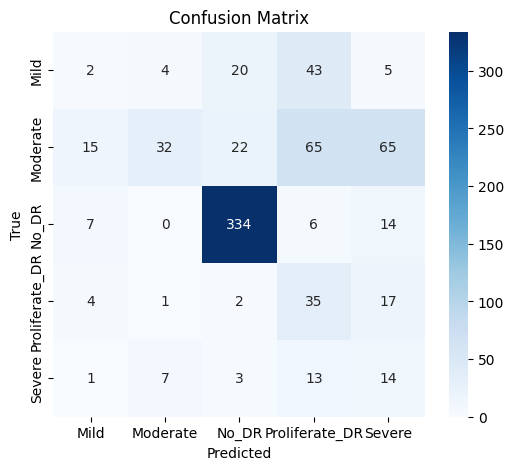

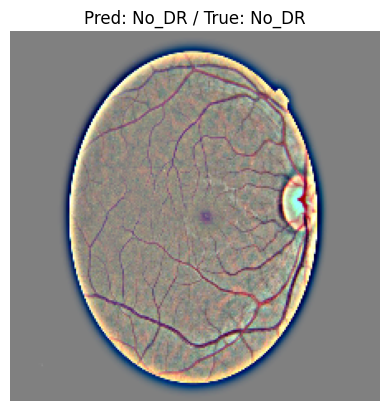

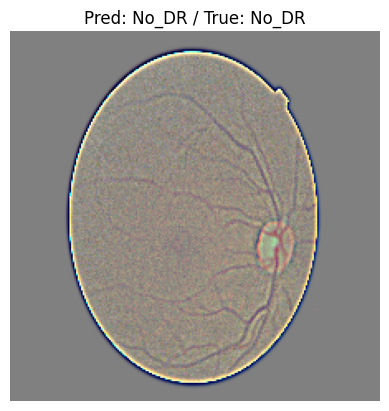

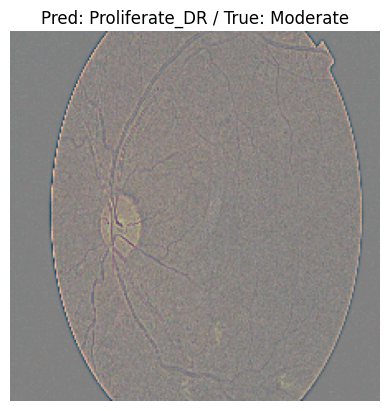

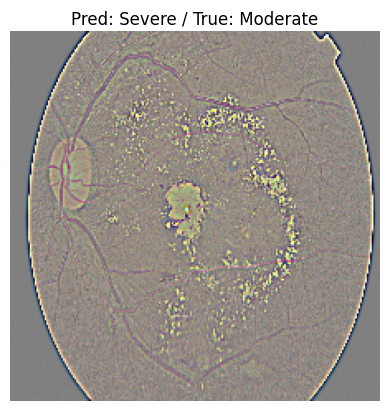

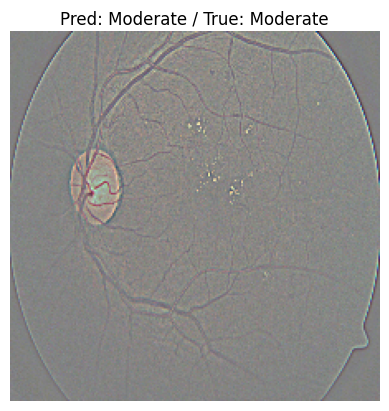

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Load your trained model (include custom metrics if you used them)
model = load_model(
    '/content/diabetic_retinopathy_model_cnn .h5',
    custom_objects={
        'f1_m': f1_m,
        'precision_m': precision_m,
        'recall_m': recall_m
    }
)

# 2. Prepare a test data generator (no augmentations, only rescale)
test_dir = '/content/APTOS/gaussian_filtered_images/gaussian_filtered_images'  # or your test-folder
img_size = (224, 224)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'   # make sure this matches how you split during training
)

# 3. Evaluate overall loss & accuracy
loss, auc, f1, prec, rec = model.evaluate(test_generator, verbose=1)
print(f"Test loss: {loss:.4f}")
print(f"Test AUC:  {auc:.4f}")
print(f"Test F1:   {f1:.4f}")
print(f"Test Prec:{prec:.4f}")
print(f"Test Rec: {rec:.4f}")

# 4. Detailed classification report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 5. Confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 6. (Optional) Show a few test images with predictions
import random
filenames = test_generator.filenames
for i in random.sample(range(len(filenames)), 5):
    img_path = test_dir + '/' + filenames[i]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"Pred: {class_labels[y_pred[i]]} / True: {class_labels[y_true[i]]}")
    plt.axis('off')
    plt.show()
